# German Traffic Sign Classification with Nueral Nets

Waymo is currently testing self-driving cars in the streets of California. This has not only gotten a lot of attention in the US but around the world. There is a group of people in Germany who are looking to provide Waymo with some funding so that they can bring self-driving cars to the German public. While companies like Mercedes and BMW are already working on self-driving cars in Germany, this group of people think bringing in Waymo to Germany will spur innovation and competition. 

Before committing to this opportunity, the group of investors want to test Waymo's self driving models. While they are fairly confident that Waymo's cameras and models can identify people and cars correctly in Germany, they are a bit less confident when it comes to traffic signs given that there can be stark differences. Thus the group of investors want to provide Waymo with some German traffic sign image data and see how well their models can classify the signs. 

Waymo is also eager to expand its training outside of the country so they have agreed to take on the first challenge of properly classifying the German traffic sign data provided by the group of German investors. Given that traffic signs can be different around the world, Waymo has opted to build a new traffic sign classification model from start. They plan to build a CNN to help identify the image data.

The image data provided is already in numerical representation so Waymo plans to do some simple image preprocessing before building a neural network. Given that this model is based on image classification there's not a lot of data analyzation or visualization that can possibly be done. They are just going to build a simple function so that they can visually sample some of the images. 

## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
#from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
%matplotlib inline
%pylab inline
np.random.seed(1)

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Importing Data

In [2]:
allDataInDict=pd.read_pickle("./data0.pickle")
allDataInDict

{'x_test': array([[[[ 58.,  59.,  61., ..., 202., 205., 203.],
          [ 49.,  52.,  55., ..., 204., 206., 204.],
          [ 44.,  49.,  54., ..., 210., 203., 203.],
          ...,
          [ 66.,  99., 103., ...,  79.,  60.,  58.],
          [ 63., 102., 103., ...,  78.,  61.,  49.],
          [ 67.,  95.,  78., ...,  79.,  58.,  58.]],
 
         [[ 51.,  51.,  47., ..., 215., 216., 216.],
          [ 45.,  52.,  51., ..., 216., 218., 217.],
          [ 40.,  47.,  48., ..., 220., 222., 218.],
          ...,
          [ 57.,  82.,  82., ...,  82.,  60.,  59.],
          [ 59.,  87.,  85., ...,  84.,  59.,  49.],
          [ 57.,  91.,  67., ...,  87.,  65.,  53.]],
 
         [[ 42.,  39.,  36., ..., 232., 233., 234.],
          [ 37.,  44.,  43., ..., 234., 236., 236.],
          [ 35.,  41.,  43., ..., 239., 242., 236.],
          ...,
          [ 41.,  74.,  82., ...,  66.,  50.,  52.],
          [ 46.,  78.,  81., ...,  70.,  51.,  47.],
          [ 45.,  83.,  64., ...,  75.

In [3]:
allDataInDict.keys()

dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])

In [4]:
print("Train Data Shape: {}".format(allDataInDict["x_train"].shape))
print("Validation Data Shape: {}".format(allDataInDict["x_validation"].shape))
print("Test Data Shape: {}".format(allDataInDict["x_test"].shape))

Train Data Shape: (86989, 3, 32, 32)
Validation Data Shape: (4410, 3, 32, 32)
Test Data Shape: (12630, 3, 32, 32)


In [5]:
trainX=np.array(allDataInDict['x_train'],dtype=np.float32)
trainY=np.array(allDataInDict['y_train'],dtype=np.float32)
validationX=np.array(allDataInDict['x_validation'],dtype=np.float32)
validationY=np.array(allDataInDict['y_validation'],dtype=np.float32)
testX=np.array(allDataInDict['x_test'],dtype=np.float32)
testY=np.array(allDataInDict['y_test'],dtype=np.float32)

## Viewing some sample images

In [6]:
def showImage(imageArray):
    array = np.zeros([32, 32, 3], dtype=np.uint8)
    array[:,:,0]=imageArray[0]
    array[:,:,1]=imageArray[1]
    array[:,:,2]=imageArray[2]
    img = Image.fromarray(array, 'RGB')
    img.save('my.png')
    #img.show()
    img=mpimg.imread('my.png')
    imgplot = plt.imshow(img)
    plt.show()
    

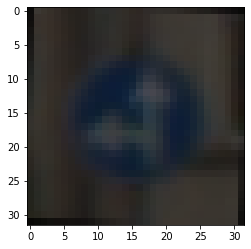

In [7]:
showImage(allDataInDict['x_train'][0])

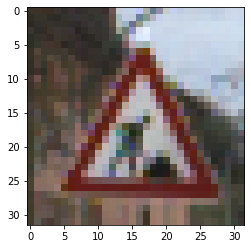

In [8]:
showImage(allDataInDict['x_test'][0])

## Pixel Scaling and Normalization

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. This can be achieved by dividing all pixels values by the largest pixel value; that is 255.

A popular data preparation technique for image data is to subtract the mean value from the pixel values. This approach is called centering, as the distribution of the pixel values is centered on the value of zero. Centering after normalization will mean that the pixels will have positive and negative values.

The distribution of pixel values often follows a Normal or Gaussian distribution, e.g. bell shape. This distribution may be present per image, per mini-batch of images, or across the training dataset and globally or per channel. As such, there may be benefit in transforming the distribution of pixel values to be a standard Gaussian: that is both centering the pixel values on zero and normalizing the values by the standard deviation. The result is a standard Gaussian of pixel values with a mean of 0.0 and a standard deviation of 1.0.

https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258

In [9]:
#Pixel normalization
trainScaledX = trainX/255
validationScaledX = validationX/255
testScaledX = testX/255

In [10]:
trainMean=np.mean(trainScaledX)
trainSTD=np.std(trainScaledX)

In [11]:
trainNormX=(trainScaledX-trainMean)/trainSTD
validationNormX=(validationScaledX-trainMean)/trainSTD
testNormX=(testScaledX-trainMean)/trainSTD

In [12]:
print("New mean on train data: {}".format(np.mean(trainNormX)))
print("New std on train data: {}".format(np.std(trainNormX)))

New mean on train data: -2.7983685413346393e-06
New std on train data: 1.0000014305114746


The images have now gone through standard pixel scaling and normalization and should now be ready to use in a neaural network.

An alternative approach is to scale the images using a preferred scaling technique just-in-time during the training or model evaluation process. Keras supports this type of data preparation for image data via the ImageDataGenerator class and API. While I continue this project, I will look to implement this instead of manually normalizing the images as this Keras class may be more computationally effective.

In [13]:
# Reshape the training and test examples 
trainX2 = np.moveaxis(trainNormX,[0,1,2,3],[0,3,1,2])
validationX2 = np.moveaxis(validationNormX,[0,1,2,3],[0,3,1,2])
testX2 = np.moveaxis(testNormX,[0,1,2,3],[0,3,1,2])


In [14]:
trainX2.shape

(86989, 32, 32, 3)

In [15]:
import tensorflow as tf

In [16]:
def oneHot(labels,C):
    One_hot_matrix = tf.one_hot(labels,C)
    return tf.keras.backend.eval(One_hot_matrix)
trainY = oneHot(trainY, 43)
validationY = oneHot(validationY, 43)
testY = oneHot(testY, 43)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 1, activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(padding = 'same',strides=2),
    tf.keras.layers.Conv2D(128, 5, activation='relu',padding="same"),
    tf.keras.layers.MaxPool2D(padding = 'same',strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
result = model.fit(x=trainX2,y=trainY,batch_size=128,epochs=2,verbose=1,shuffle=False,initial_epoch=0)

Epoch 1/2
86989/86989 [==============================] - 1775s 20ms/sample - loss: 0.4928 - acc: 0.8607
Epoch 2/2
86989/86989 [==============================] - 1675s 19ms/sample - loss: 0.0454 - acc: 0.9869


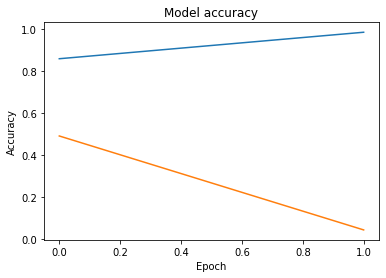

In [19]:
plt.plot(result.history['acc'])
plt.plot(result.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [20]:
valid = model.evaluate(validationX2,validationY,verbose=2)

4410/4410 - 34s - loss: 0.2367 - acc: 0.9417


In [21]:
test = model.evaluate(testX2,testY,verbose=2)

12630/12630 - 97s - loss: 0.4107 - acc: 0.9267
